In [1]:
from helpers.helper_functions import read_and_set_df, pd, np, msno, go, plt, sns, px, tf

In [2]:
X_train = pd.read_csv('data/x_train_clean.csv', sep='$', decimal=".", engine='python') 
y_train = pd.read_csv('data/y_train_clean.csv', sep='$', decimal=".", engine='python')   
X_test = pd.read_csv('data/x_test_clean.csv', sep='$', decimal=".", engine='python') 
y_test = pd.read_csv('data/y_test_clean.csv', sep='$', decimal=".", engine='python') 

del X_train['Unnamed: 0']
del y_train['Unnamed: 0']
del X_test['Unnamed: 0']
del y_test['Unnamed: 0']

In [3]:
# Pakete für den Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, make_scorer, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import json

# Import Test Set

In [4]:
test_data_df = pd.read_csv('./data/test.csv', sep='[,$]' , decimal=".", engine='python')

test_data_df.columns = test_data_df.columns.str.lower()

test_data_df.rename(columns={
    'id': 'id',
    'gender': 'gender',
    'age': 'age',
    'driving_license': 'driving_license',
    'region_code': 'region_code',
    'previously_insured': 'previously_insured',
    'vehicle_age': 'vehicle_age',
    'vehicle__damage': 'vehicle_damage',
    'annual__premium': 'annual_premium',
    'policy_sales_channel': 'policy_sales_channel',
    'vintage': 'vintage'
},
    inplace=True)


index_max_age = test_data_df[test_data_df["age"] >= 100].index
test_data_df.drop(index_max_age, inplace=True)

index_min_age = test_data_df[test_data_df["age"] < 18].index
test_data_df.drop(index_min_age, inplace=True)

index_min_premium = test_data_df[test_data_df["annual_premium"] <= 0].index
test_data_df.drop(index_min_premium, inplace=True)

index_max_premium = test_data_df[test_data_df["annual_premium"] >= 150000].index
test_data_df.drop(index_max_premium, inplace=True)

def map_categorials(df):

    vehicle_age_map = {
        '< 1 Year': 0,
        '1-2 Year': 1,
        '> 2 Years': 2
    }

    vehicle_damage_map = {
        'No': 0,
        'Yes': 1
    }

    df.loc[:,'vehicle_age'] = df['vehicle_age'].map(vehicle_age_map).astype('Int64')
    df.loc[:,'vehicle_damage'] = df['vehicle_damage'].map(vehicle_damage_map)

    LE = LabelEncoder()
    df['region_code'] = LE.fit_transform(df.loc[:,'region_code'])
    df['gender'] = LE.fit_transform(df.loc[:, 'gender'])

    return df

test_data_df_label_encoded = map_categorials(test_data_df)

## Random Forest Classifier Test Set

<ipython-input-5-9631c678bb94>:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



vehicle_damage          0.204714
age                     0.119109
vehicle_age             0.100629
vintage                 0.092050
gender                  0.087106
annual_premium          0.086682
driving_license         0.085792
previously_insured      0.075280
policy_sales_channel    0.074819
region_code             0.073817
dtype: float64


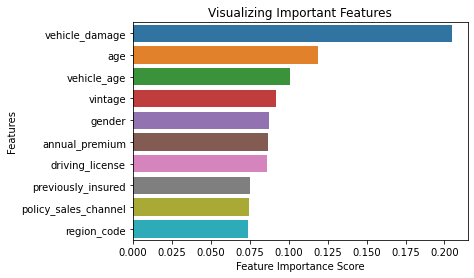

In [5]:

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(test_data_df.drop('id', axis=1))

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

sns.barplot(x=feature_scores, y=feature_scores.index)# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
# cf_matrix = confusion_matrix(y_test['response'], y_pred)
# cf_matrix

## Random Forest Classifier Train Set

In [6]:
def get_auc_pr(y_test_df, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test_df, y_proba)
    return auc(recall, precision)

# grater_is_better = höhere Werte sind besser - keine loss function 
scorer_auc_pr = make_scorer(get_auc_pr, greater_is_better = True, needs_proba=True)


def create_random_forest_model(X_train, y_train):

    # Hyperparameter-Tuning definieren
    rf_classifier = RandomForestClassifier(random_state = 42, n_jobs = -1, class_weight='balanced_subsample')

    # Intervalle für das Tuning festlegen
    params = {
        'n_estimators': [250, 500, 1000, 1500],                              #250, 500, 1000, 1500
        'max_depth': [5, 10, 50, 100, 200, None],                    #5, 10, 20, 30, 50, 100, 200, None
        'min_samples_split': [2, .1,.5], 
        'min_samples_leaf': [1 , 3, 9],
        'max_features': [.01, .05, .05, 'log2', "sqrt", 'auto']
    }

    cv = RandomizedSearchCV(rf_classifier,
                            params,
                            n_iter = 1000,                                     #1000
                            scoring= make_scorer(roc_auc_score),
                            cv = 5,                                            #5
                            n_jobs = -1,
                            random_state = 42)
    

    # Tuning durchführen 
    print('Starte Hyperparameter-Tuning')
    cv.fit(X_train, y_train)
    print('Tuning beendet')

    print(cv.best_params_)
    best_params = cv.best_params_
    model_rf = cv.best_estimator_

    # Ergebnisse speichern
    file_name = './data/random_forest' 
    with open(file_name + '_params.json', 'w') as outfile:
        json.dump(best_params, outfile, indent = 4)
    
    return model_rf 

#### Modell ausführen

In [7]:
# Modell ausführen
model_rf = create_random_forest_model(X_train, y_train)

Starte Hyperparameter-Tuning


In [ ]:
Y_pred = model_rf.predict(X_test)
acc_rf = round(model_rf.score(X_test, y_test) * 100,2)


# Modell Evaluation
# Hier können wir dann alle Modell anhand von verschiedenen Gütemaßen in einer Tabelle vergleichen 
models = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [acc_rf]
})

# Die cmpa wird erst bei mehreren Zeilen richtig angezeigt
models.sort_values(by='Score', ascending=False).style.background_gradient(cmap='Greens',subset = ['Score'])   

,Model,Score
0,Random Forest,88.510000


#### Visuelle Darstellung der Confusion Matrix

<AxesSubplot:>

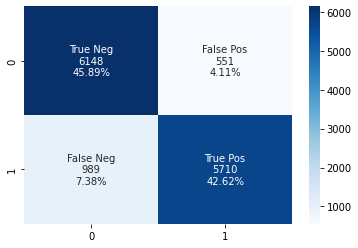

In [ ]:
# Erstellun der Confusion Matrix
cf_matrix = confusion_matrix(y_test['response'], Y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]


labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
y_proba = model_rf.predict_proba(X_test)[:,1]
print(y_proba)
pd.DataFrame(precision_recall_curve(y_test[['response']], y_proba))

[0.002 0.728 0.332 ... 0.994 0.992 0.942]


,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,0.5,0.624580,0.648489,0.657112,0.661659,0.665540,0.668231,0.670977,0.673069,0.675038,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,1.0,0.999851,0.999403,0.999254,0.999254,0.999254,0.999104,0.999104,0.999104,0.999104,...,0.275862,0.260188,0.241081,0.221227,0.198537,0.174354,0.140469,0.104195,0.055083,0.0
2,0.0,0.002000,0.004000,0.006000,0.008000,0.010000,0.012000,0.014000,0.016000,0.018000,...,0.984000,0.986000,0.988000,0.990000,0.992000,0.994000,0.996000,0.998000,1.000000,NaN


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test['response'], y_proba)

fpr, tpr, _ = roc_curve(y_test['response'], y_proba)
auc_score = roc_auc_score(y_test['response'], y_proba)


fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

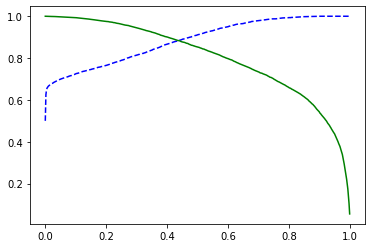

In [ ]:
# precision recall threshold curve
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precision, recall, thresholds)